# RAG
In this section we will start to see the glimpses of RAG. We start by figuring out how to handle external documents. We have already been exposed to building a database in the previous section, and we will use this knowledge to build a database over an example document.

As with data storage, we have many, _**many**_ options for processing external documents. In this section we will make use of LlamaIndex. The approach will likely vary depending on the nature of your documents - html, pdf, word, folders, etc.

Here, we focus on parsing a single PDF using `llama_index` and `PyMuPDFReader`.

In [1]:
# this is necessary for chromadb to not throw an error 
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [2]:
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter

from pydantic import BaseModel, Field

import fitz

from PIL import Image
import matplotlib.pyplot as plt

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

import dotenv
import os

from openai import OpenAI

from jinja2 import Environment, FileSystemLoader, select_autoescape
from typing import Any

dotenv.load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
loader = PyMuPDFReader()
documents = loader.load(file_path="data/Dombrovski et al. - 2023 - Synaptic gradients transform object location to ac.pdf")

In [4]:
len(documents)

33

This list contains 1 item for each page.

In [5]:
print(documents[0].text[:1000] + "...")

534  |  Nature  |  Vol 613  |  19 January 2023
Article
Synaptic gradients transform object 
location to action
Mark Dombrovski1,6, Martin Y. Peek2,6, Jin-Yong Park2,6, Andrea Vaccari3, Marissa Sumathipala2, 
Carmen Morrow2, Patrick Breads2, Arthur Zhao2, Yerbol Z. Kurmangaliyev1, Piero Sanfilippo1, 
Aadil Rehan1, Jason Polsky2, Shada Alghailani2, Emily Tenshaw2, Shigehiro Namiki2,4, 
S. Lawrence Zipursky1 ✉ & Gwyneth M. Card2,5 ✉
To survive, animals must convert sensory information into appropriate behaviours1,2. 
Vision is a common sense for locating ethologically relevant stimuli and guiding 
motor responses3–5. How circuitry converts object location in retinal coordinates to 
movement direction in body coordinates remains largely unknown. Here we show 
through behaviour, physiology, anatomy and connectomics in Drosophila that 
visuomotor transformation occurs by conversion of topographic maps formed by  
the dendrites of feature-detecting visual projection neurons (VPNs)6,7 into syn

## Extracting images
It is probably handy to have the images extracted from the pdf. This is not always easy to do, but for this paper, we can use PyMuPDF to extract the images. Objects in a pdf are identified by a `xref` (cross reference) number.

If you know this number, you can extract the image. But how do you find the `xref` number? One method is use PyMuPDF's image extraction functions. We can just loop through all `xref`s and try and extract the image. If it doesn't work, then it's not an image! PyMuPDF will do most of this for us.

In [6]:
def get_images(path: str):
    doc = fitz.open(path)
    for p, page in enumerate(doc):
        images = page.get_images()
        if len(images) > 0:
            print(f"Page {p} has {len(images)} images")
            for i, img in enumerate(images):
                xref = img[0]
                mref = img[1]
                basepix = fitz.Pixmap(doc,xref)
                maskpix = fitz.Pixmap(doc,mref)
                pix = fitz.Pixmap(basepix, maskpix)
                pix.save(f"./data/page_{p}_image_{i}.png")
    print("Done")


In [7]:

def get_images(path):
    """
    Extract images from PDF with proper error handling for invalid xrefs
    """
    doc = fitz.open(path)
    
    # Create output directory if it doesn't exist
    os.makedirs("./data", exist_ok=True)
    
    total_images = 0
    
    for p in range(len(doc)):
        page = doc[p]
        images = page.get_images()
        
        print(f"Page {p}: Found {len(images)} images")
        
        for i, img in enumerate(images):
            xref = img[0]  # Image xref
            mref = img[1]  # Mask xref (can be 0 if no mask)
            
            try:
                # Always create the base pixmap
                basepix = fitz.Pixmap(doc, xref)
                
                # Only create mask pixmap if mref is valid (non-zero)
                if mref != 0:
                    try:
                        maskpix = fitz.Pixmap(doc, mref)
                        # Create combined pixmap with mask
                        pix = fitz.Pixmap(basepix, maskpix)
                        maskpix = None  # Clean up
                    except ValueError as e:
                        print(f"Warning: Could not create mask for image {i} on page {p}: {e}")
                        # Use base pixmap without mask
                        pix = basepix
                else:
                    # No mask reference, use base pixmap
                    pix = basepix
                
                # Convert to RGB if needed (some images might be in CMYK or other formats)
                if pix.n - pix.alpha < 3:  # Not RGB
                    pix = fitz.Pixmap(fitz.csRGB, pix)
                
                # Save the image
                filename = f"./data/page_{p}_image_{i}.png"
                pix.save(filename)
                print(f"Saved: {filename}")
                
                # Clean up pixmaps
                pix = None
                basepix = None
                total_images += 1
                
            except ValueError as e:
                print(f"Error processing image {i} on page {p}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error processing image {i} on page {p}: {e}")
                continue
    
    doc.close()
    print(f"Done! Extracted {total_images} images total.")

# Alternative approach: Extract all images without masks
def get_images_simple(path):
    """
    Simplified image extraction that avoids mask-related issues
    """
    doc = fitz.open(path)
    
    # Create output directory if it doesn't exist
    os.makedirs("./data", exist_ok=True)
    
    total_images = 0
    
    for p in range(len(doc)):
        page = doc[p]
        images = page.get_images()
        
        print(f"Page {p}: Found {len(images)} images")
        
        for i, img in enumerate(images):
            xref = img[0]
            
            try:
                # Get image data directly
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]
                
                # Save the image with original format
                filename = f"./data/page_{p}_image_{i}.{image_ext}"
                with open(filename, "wb") as f:
                    f.write(image_bytes)
                
                print(f"Saved: {filename}")
                total_images += 1
                
            except Exception as e:
                print(f"Error extracting image {i} on page {p}: {e}")
                continue
    
    doc.close()
    print(f"Done! Extracted {total_images} images total.")


In [8]:
get_images("data/Dombrovski et al. - 2023 - Synaptic gradients transform object location to ac.pdf")

Page 0: Found 1 images
Saved: ./data/page_0_image_0.png
Page 1: Found 21 images
Saved: ./data/page_1_image_0.png
Saved: ./data/page_1_image_1.png
Saved: ./data/page_1_image_2.png
Saved: ./data/page_1_image_3.png
Saved: ./data/page_1_image_4.png
Saved: ./data/page_1_image_5.png
Saved: ./data/page_1_image_6.png
Saved: ./data/page_1_image_7.png
Saved: ./data/page_1_image_8.png
Saved: ./data/page_1_image_9.png
Saved: ./data/page_1_image_10.png
Saved: ./data/page_1_image_11.png
Saved: ./data/page_1_image_12.png
Saved: ./data/page_1_image_13.png
Saved: ./data/page_1_image_14.png
Saved: ./data/page_1_image_15.png
Saved: ./data/page_1_image_16.png
Saved: ./data/page_1_image_17.png
Saved: ./data/page_1_image_18.png
Saved: ./data/page_1_image_19.png
Saved: ./data/page_1_image_20.png
Page 2: Found 36 images
Saved: ./data/page_2_image_0.png
Saved: ./data/page_2_image_1.png
Saved: ./data/page_2_image_2.png
Saved: ./data/page_2_image_3.png
Saved: ./data/page_2_image_4.png
Saved: ./data/page_2_image_

If we inspect one of these images, we can see that sure enough, it is a correct image.

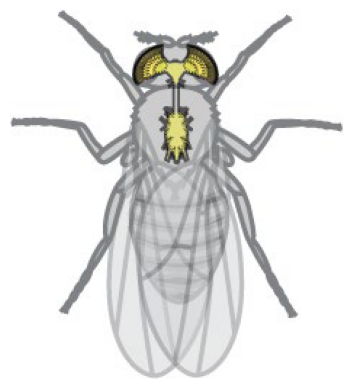

In [9]:
img = Image.open("data/page_1_image_0.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In some cases, this might not be possible. Another method is to convert the pdf pages to images. We can then pass the images to a vision LLM and ask it to extract the images. 

## Creating a vector database

Now we have our documents, we can create a vector database. We will use Chroma as before.

First, we use the `text_parser` we created before to split the documents into chunks, and create indices. Essentially, the process is:

- Split the document into chunks;
- Add the chunks to a list;
- Add the chunks to a database, assigning a unique index, and any metadata to the chunks.

The splitting can occur in a few different ways: at `.`, page-breaks, paragraphs, sentences. You can also choose different chunk sizes and overlap sizes.

We use the `SentenceSplitter` from LlamaIndex, and just pick some generic parameters.

In [10]:
def chunker(chunk_size: int, overlap: int, documents: Any) -> tuple[list[str], list[int]]:
    text_parser = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
    )

    text_chunks = []
    doc_idxs = []
    for doc_idx, doc in enumerate(documents):
        cur_text_chunks = text_parser.split_text(doc.text)
        text_chunks.extend(cur_text_chunks)
        doc_idxs.extend([doc_idx] * len(cur_text_chunks))

    return text_chunks, doc_idxs

text_chunks, doc_idxs = chunker(chunk_size=2048, overlap=128, documents=documents)

len(text_chunks)

40

Reusing roughly the same database structure as before:

In [ ]:
class DocumentDB:
    def __init__(self, name: str, model_name: str = "text-embedding-3-small"):
        self.model_name = model_name
        self.client = chromadb.PersistentClient(path="./")
        self.embedding_function = OpenAIEmbeddingFunction(api_key=OPENAI_API_KEY, model_name=model_name)
        self.chat_db = self.client.create_collection(name=name, embedding_function=self.embedding_function, metadata={"hnsw:space": "cosine"})
        self.id_counter = 0


    def add_chunks_to_db(self, chunks: list[str], doc_idxs: list[int], metadata: dict = {}):
        """Add text chunks to the database.

        Args:
            chunks (list[str]): List of text chunks.
            doc_idxs (list[int]): List of corresponding document indices.
        """
        self.chat_db.add(
            documents=chunks,
            metadatas=[{"doc_idx": idx} for idx in doc_idxs],
            ids=[f"chunk_{self.id_counter + i}" for i in range(len(chunks))]
        )
        self.id_counter += len(chunks)


    def get_all_entries(self) -> dict:
        """Grab all of the entries in the database.

        Returns:
            dict: All entries in the database.
        """
        return self.chat_db.get()
    

    def clear_db(self, reinitialize: bool = True):
        """Clear the database of all entries, and reinitialize it.

        Args:
            reinitialize (bool, optional): _description_. Defaults to True.
        """
        self.client.delete_collection(self.chat_db.name)
        # re-initialize the database
        if reinitialize:
            self.__init__(self.chat_db.name, self.model_name)


    def query_db(self, query_text: str, n_results: int = 2) -> dict:
        """Given some query text, return the n_results most similar entries in the database.

        Args:
            query_text (str): The text to query the database with.
            n_results (int): The number of results to return.

        Returns:
            dict: The most similar entries in the database.
        """
        return self.chat_db.query(query_texts=[query_text], n_results=n_results)

Now we add our chunks to the database:

In [25]:
# only add non empty chunks 
new_chunks = []
new_indices = []
for achunk, anidx in zip(text_chunks, doc_idxs): 
    if len(achunk)>0: 
        new_chunks.append(achunk)
        new_indices.append(anidx)

text_chunks = new_chunks
doc_idxs = new_indices

In [27]:
doc_db = DocumentDB("paper_db_test7")

doc_db.add_chunks_to_db(chunks=text_chunks, doc_idxs=doc_idxs)

If you have already created the database then you will get an error if you try to run this again. You'll need to delete the `chroma.sqlite3` file and the folder with a name consisting of a long string of numbers and letters.

We now try a query and see what results we get back:

In [29]:
sample_query = "DNp02"
results = doc_db.query_db(sample_query, n_results=3)
print(f"Sample query results for '{sample_query}':")
results

Sample query results for 'DNp02':


{'ids': [['chunk_2', 'chunk_20', 'chunk_22']],
 'embeddings': None,
 'documents': [['GF\nFly\nCNS\nD\nL\nFraction of DN’s synaptic input\ne\nn = 358 596 289 115\n38\n87\n279 258\n128\n253\n–100\n–50\n0\n50\n100\nDNp06\nDNp05\nDNp03\nDNp04\nGF\nDNp02, DNp04,\nDNp06\nDNp02, DNp04\nDNp02\nEmpty\nDNp11\nΔ[T2 angle (°)]\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n•\n• •\n•\n• •\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•••\n•\n•\n• •\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n• •\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n• •\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n•\n•\n•\n•\n•\n• •\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n•\n••\n•\n•\n•\n••\n•\n•\n•\n•\n•\n•\n•\n•

This is all pretty messy, but we can see that we have

`'documents'` The documents returned by the database query

`'metadatas'` Any metadata we wanted to include, in this case only the index. But we could easily include the author and title of the paper...

`'distances'` The similarity measure between the query and the returned context.

The next step is to put these contexts, along with the query, into an LLM.

In [30]:
client = OpenAI()

Our prompt will be simple for now. We use the standard way to load Jinja templates.

In [31]:
def load_template(template_filepath: str, arguments: dict[str, Any]) -> str:
    env = Environment(
        loader=FileSystemLoader(searchpath='./'),
        autoescape=select_autoescape()
    )
    template = env.get_template(template_filepath)
    return template.render(**arguments)

system_prompt = load_template(
    template_filepath="prompts/documents/rag_system_prompt.jinja",
    arguments={}
)

---
```
You are a helpful academic assistant that is an expert at extracting information from academic papers. You will be given a query, and some chunks of text that corresponds to a document. You will also be given the cosine similarity of the query with the text chunks.
You must answer the query using the information in the text.
Your answer must be concise and to the point.
If you are unsure of something, you should say that you are unsure.

### Input Format ###

Query: <query>
Context: <text chunk>\n\n"
Cosine Similarity: <similarity>
----------
```
---

We now need to combine the call to the retriever, along with combining the context into a function.

In [56]:
functions = 'abd_SAG_IN_input oviposition,abdominal_terminalia_bristle oviposition, egg_laying,input to clock neurons,input to clock neurons,input to clock neurons,aMe12 visual_chromatic,AN03A001 walking,AN05B023 pheromone,AN06B011 stride; walking,AN07B033 grooming,AN07B038 grooming,AN07B043 grooming,AN07B047 grooming,AN07B067 grooming,AN08B022 puff,AN08B031 sine_song; wing_vibration,AN08B043 sine_song; wing_vibration,AN08B059 sine_song; wing_vibration,AN08B069 sine_song; wing_vibration,AN08B134 proboscis_extension,AN09B017 pheromone,AN10B001 turning,AN10B005 rest,AN19A018 halting,AN27X004 flight_induction,AN27X005 walking,AN27X008 flight_induction,AOTU019 frontal visual field object detection; steer object towards midline; increase forward velocity,AOTU025 lateral visual field object detection; steer object towards midline,CB0726 heart; neuromodulatory,CB0905 heart; neuromodulatory,CMU uterine_contraction; egg_laying,CRZ01,CRZ02 heart; neuromodulatory,CvN_A1 neck_motor,CvN_A2 neck_motor,CvN1-3 neck_motor,CvN2 neck_motor,CvN3 neck_motor,CvN4 neck_control; neck_motor,CvN5 neck_control; neck_motor,CvN5-8 neck_motor,CvN6 neck_control; neck_motor,CvN6-8 neck_motor,CvN7 neck_control; neck_motor,D_adPN dangerous,DA1_lPN cVA male pheromone detection,DA1_vPN pheromones,DA2_lPN geosmin sensing; dangerous,DA3_adPN fruity,DA4l_adPN bacterial metabolite indole detection; dangerous; olfactory,DC1_adPN fruity/dangerous,DC2_adPN plant_matter,DC3_adPN pheromones,DC4_adPN dangerous,DC4_vPN dangerous,dCH visual_horizontal_widefieldmotion,DL1_adPN fruity,DL2d_adPN decaying_fruit,DL2d_vPN decaying_fruit,DL2v_adPN decaying_fruit,DL3_lPN pheromones,DL4_adPN sex pheromone of the parasitic wasp L.boulardi; dangerous,DL5_adPN alcoholic_fermentation/dangerous/plant_matter; olfactory,DM1_lPN yeasty,DM2_lPN alcoholic_fermentation/fruity,DM3_adPN yeasty/fruity/dangerous,DM3_vPN yeasty/fruity/dangerous,Dm3b Stripe-selective,DM4_adPN yeasty,DM4_vPN yeasty,DM5_lPN yeasty,DM6_adPN yeasty,Dm8 visual_chromatic; phototaxis; visual,Dm8a UV pooling,Dm8b UV pooling,Dm9 Color opponent; visual_chromatic,polarization sensitive neuron, R7d input to DmDRA1,polarization sensitive neuron, R8d input to DmDRA2,dMS9 singing; wing_vibration,DNa01 ipsiversive, low gain steering; turning,DNa02 ipsiversive, high gain steering,DNa03 turning; walking,DNa04 flight,DNa11 turning; walking,DNa12 abdomen_curl; abdomen_motion,DNa15 turning; flight,DNae003 turning; walking,DNb01 turning; flight,DNb02 turning,DNb05 ipsiversive steering; turning,DNb06 contraversive steering; turning,DNc01 reproduction, feeding,DNc02 reproduction, feeding,DNg02 forward; flight,DNg100 forward; walking,DNg104 neuromodulatory,DNg11 leg_rubbing; grooming,DNg12 leg_rubbing, head_sweeps; grooming,DNg13 ipsiversive steering; turning; walking,DNg14 abdomen_curl; abdomen_motion,DNg22 neuromodulatory,DNg26 reproduction,DNg28 feeding,DNg30 neuromodulatory,DNg34 neuromodulatory,DNg55 walking,DNg62 antennal_grooming; grooming,DNg66 neuromodulatory,DNg70 neuromodulatory,DNg75 forward; walking,DNg97 forward; walking,DNge011 antennal_grooming; grooming,DNge012 antennal_grooming; grooming,DNge050 walking,DNge053 walking,DNge078 antennal_grooming; grooming,DNge138 neuromodulatory,DNge149 neuromodulatory,DNge150 neuromodulatory,DNge152 neuromodulatory,DNge172 oviposition,DNp01 escape_takeoff,DNp02 backward-jumping; escape_takeoff,DNp03 turning; flight,DNp04 escape_takeoff,DNp06 turning, flight; escape_takeoff,DNp07 landing,DNp09 turning on unilateral activation; forward on bilateral activation; abdomen_curl; freezing,DNp10 landing,DNp11 forward-jumping; escape_takeoff,DNp13 oviposition; reproduction,DNp15 turning, walking, flight,DNp20 ocellar,DNp22 ocellar,DNp25 thermo_hygro;,DNp27 neuromodulatory,DNp28 ocellar,DNp29 neuromodulatory,DNp30 neuromodulatory; hunger,DNp32 neuromodulatory,DNp37 vaginal_plate_opening,DNp42 backwards,DNp42 backing up; geosmin avoidance,DNp44 thermo_hygro;,DNp62 neuromodulatory; hunger,DNpe048 neuromodulatory,DNx02 neck_motor,DP1l_adPN alcoholic_fermentation,DP1l_vPN alcoholic_fermentation,DP1m_adPN alcoholic_fermentation,DP1m_vPN alcoholic_fermentation,dPR1 prothoracic song neuron,EPG heading direction,FC2 allocentric goal,FD1 visual_horizontal_widefieldmotion; visual,FD3 visual_horizontal_widefieldmotion; visual,H1 visual_horizontal_widefieldmotion; visual,H2 visual_horizontal_widefieldmotion; visual,HBeyelet circadian photosensitivity,HSE Horizontal flow; visual_horizontal_widefieldmotion; visual,HSN Horizontal flow; visual_horizontal_widefieldmotion; visual,HSS Horizontal flow; visual_horizontal_widefieldmotion; visual,HST Horizontal flow,il3LN6 increase left-right contrast in DA1_lPN,clock neuron,L1 ON motion input,L2 OFF motion input,L3 OFF motion support,L4 Forward motion,LAL073 bidirectional regulation of walking speed; scale odour-evoked run length,LAL089 turning; lower speed; odour-evoked offset search,LAL091 turning; lower speed; odour-evoked offset search,LAL093 turning; lower speed; odour-evoked offset search,LC10a visual_small_object; courtship; visual,LC10b visual_small_object; visual,LC10c visual_small_object; visual,LC10d visual_small_object; visual,LC10e visual_small_object; visual,LC11 Small object; visual_small_object; visual,LC12 visual_loom, visual_large_objects, visual_small_object; visual,LC15 visual_thin_vertical_bar, visual_large_objects; visual,LC16 Retreat behavior; visual_loom; backwards, freezing; walking,LC17 visual_loom, visual_large_objects, visual_small_object; visual,LC18 small object detection,LC21 visual_small_object; visual,LC25 complex line motion; visual_thin_vertical_bar; visual,LC26 visual_loom, visual_small_object; visual,LC4 Looming detector; visual_loom; flight; escape_takeoff, visual,LC6 visual_loom, visual_small_object; flight; escape_takeoff,LC9 visual_loom, visual_small_object; courtship; backward walking,LHAV1a1 aversive odour processing,LPLC1 visual_loom; visual,LPLC2 Looming escape,LPT04_HST visual_horizontal_widefieldmotion,LPT21 visual_horizontal_widefieldmotion,LPT22 visual_horizontal_widefieldmotion,LPT23 visual_horizontal_widefieldmotion,LPT26 visual_horizontal_widefieldmotion,LPT27 visual_vertical_widefieldmotion,LPT28 visual_vertical_widefieldmotion,LPT30 visual_vertical_widefieldmotion,LPT31 visual_vertical_widefieldmotion,LPT42_Nod4 visual_horizontal_widefieldmotion,LPT45_dCal1 visual_vertical_widefieldmotion,LPT47_vCal2 visual_vertical_widefieldmotion,LPT48_vCal3 visual_vertical_widefieldmotion,LPT49 visual_vertical_widefieldmotion,LPT50 visual_vertical_widefieldmotion,M_l2PN10t19 decaying_fruit; thermohygro; thermo_hygro; thermosensory,M_l2PNm17 thermo_hygro,M_lPNm11A thermo_hygro,M_lv2PN9t49 thermo_hygro,M_lvPNm48 humid_heating_olf; thermohygro; thermohygro,M_smPNm1 thermo_hygro; thermosensory,M_vPNml60 thermo_hygro,M_vPNml61 thermo_hygro,M_vPNml62 thermo_hygro,MBON01 appetitive,MBON02 appetitive,MBON03 appetitive,MBON04 appetitive,MBON05 appetitive,MBON06 olfactory, appetitive_learning; appetitive,MBON07 appetitive,MBON09 olfactory, visual; aversive,MBON10 aversive,MBON11 hunger; aversive,MBON12 aversive,MBON13 aversive,MBON14 appetitive_learning; aversive,MBON15 aversive,MBON15-like aversive,MBON16 thermohygro; aversive,MBON17 aversive,MBON17-like aversive,MBON18 aversive,MBON19 visual; aversive,MBON20 aversive,MBON21 appetitive,MBON23 aversive,MBON24 mechanosensory, gustatory; appetitive,MBON25 appetitive,MBON26 thermohygro; appetitive,MBON27 visual; appetitive,MBON28 aversive,MBON29 appetitive,MBON30 aversive,MBON31 aversive,MBON32 visual, aversive,MBON33 visual, aversive,MBON34 aversive,MBON35 visual,MDN backwards walking,MeMe_e10 visual_polarized_light,mesVUM-MJ flight,MeTu1 visual_thin_vertical_bar,MeTu2a visual_polarized_light,MeTu2b visual_polarized_light,MeTu3a visual_polarized_light,MeTu3b visual_chromatic,MeTu3c visual_chromatic,MeTu4a visual,MeTu4b visual,MeTu4c visual,MeTu4d visual,Mi1 ON delayed input,Mi4 ON inhibitory,Mi9 sustained input,MTe50 visual_chromatic; visual,MZ_lvPN thermo_hygro; thermohygro,Nod1 visual_horizontal_widefield motion,Nod2 visual_horizontal_widefield motion,Nod3 visual_horizontal_widefield motion,Nod5 visual_vertical_widefieldmotion,ORN_DA1 cVA male pheromone detection,ORN_DA2 geosmin sensing,ORN_DA4l bacterial metabolite indole detection,ORN_DL4 sex pheromone of the parasitic wasp L.boulardi,oviDNa oviposition, abdomen_curl,oviDNa_a oviposition, abdomen_curl,oviDNa_b oviposition, abdomen_curl,oviDNb oviposition, abdomen_curl,oviIN oviposition,P1 courtship song,P2b courtship,PAM01 appetitive_learning; appetitive,PAM01 appetitive_learning; appetitive,PAM02 appetitive_learning; appetitive,PAM03 appetitive_learning; appetitive,PAM04 appetitive_learning; appetitive,PAM05_a appetitive_learning; appetitive,PAM05_b appetitive_learning; appetitive,PAM06 appetitive_learning; appetitive,PAM07 appetitive_learning; appetitive,PAM08_a appetitive_learning; appetitive,PAM08_a appetitive_learning; appetitive,PAM08_b appetitive_learning; appetitive,PAM09 appetitive_learning; appetitive,PAM10 appetitive_learning; appetitive,PAM11 appetitive_learning; appetitive,PAM12 appetitive_learning; appetitive,PAM13 appetitive_learning; appetitive,PAM14 appetitive_learning; appetitive,pC1a oviposition, vaginal_plate_opening, abdomen_curl, reproduction, sine_song, pulse_song, courtship, egg_laying,pC1b oviposition, vaginal_plate_opening, abdomen_curl, reproduction, sine_song, pulse_song, courtship, egg_laying,pC1c oviposition, vaginal_plate_opening, abdomen_curl, reproduction, sine_song, pulse_song, courtship, egg_laying,pC1d oviposition, vaginal_plate_opening, abdomen_curl, reproduction, sine_song, pulse_song, courtship, egg_laying, aggression,pC1e oviposition, vaginal_plate_opening, abdomen_curl, reproduction, sine_song, pulse_song, courtship, egg_laying, aggression,PFL2 slowing & turning,PFL3 compare allocentric heading vs. goal angles,pIP10 courtship song,PPL101 olfactory; aversive,PPL102 aversive,PPL106 gustatory; aversive,putative_abd_Dsx_OA egg_laying; motor,putative_abd_ppk oviposition, egg_laying; reproduction,putative_PU oviposition, egg_laying; reproduction,putative_SPSN egg_laying, oviposition; reproduction,R1-R6 Achromatic vision,R7d polarized UV detection,R7p UV detection,R7y UV detection,R8d polarized UV detection,R8p Blue detection,R8y green detection,SA_VTV_1 chemosensory,SA_VTV_10 chemosensory,SA_VTV_2 chemosensory,SA_VTV_3 chemosensory,SA_VTV_4 chemosensory,SA_VTV_5 chemosensory,SA_VTV_6 chemosensory,SA_VTV_7 chemosensory,SA_VTV_8 chemosensory,SA_VTV_9 chemosensory,SA_VTV_DProN_1 chemosensory,SAch01 chemosensory,SAch02 chemosensory,SAchxx chemosensory,SAG mating_status; reproduction,SAG-like reproduction,SApp01 haltere,SApp02 haltere,SApp03 haltere,SApp04 notum,SApp05 haltere,SApp06 haltere,SApp07 haltere,SApp08 haltere,SApp10 notum,SApp11 notum,SApp12 haltere,SApp13 notum,SApp14 notum,SApp15 haltere,SApp17 haltere,SApp18 notum,SApp19 notum,SApp20 notum,SApp21 notum,SApp22 haltere,SApp23 leg,SAppxx haltere,SAxx02 nociception,SMP092 activation: reduce groundspeed,SMP550 oviposition; reproduction,SNpp19 prosternal,SNxx27 nociception,SNxx29 nociception,SNxx31 wing,T4a ON front-to-back motion,T4b ON back-to-front motion,T4c ON upward motion,T4d ON downward motion,T5a OFF motion detector,T5b OFF motion detector,T5c OFF motion detector,T5d OFF motion detector,Tm1 OFF delayed input,Tm2 OFF fast input,Tm3 ON fast input,Tm4 OFF excitatory,Tm5b UV,Tm5c Green detection'
print(','.join(set(str.split(functions, ','))))

PFL3 compare allocentric heading vs. goal angles,DP1m_vPN alcoholic_fermentation,MBON06 olfactory,DNge150 neuromodulatory,D_adPN dangerous,LPT23 visual_horizontal_widefieldmotion,putative_abd_Dsx_OA egg_laying; motor,SApp06 haltere, oviposition; reproduction,DNge078 antennal_grooming; grooming,putative_abd_ppk oviposition,AOTU019 frontal visual field object detection; steer object towards midline; increase forward velocity,DP1m_adPN alcoholic_fermentation,MeTu2a visual_polarized_light,pC1e oviposition, visual_small_object; visual,PAM04 appetitive_learning; appetitive,DNa12 abdomen_curl; abdomen_motion,LPT22 visual_horizontal_widefieldmotion,MBON14 appetitive_learning; aversive,DNp10 landing,LPLC2 Looming escape,DL5_adPN alcoholic_fermentation/dangerous/plant_matter; olfactory,DNge050 walking,H1 visual_horizontal_widefieldmotion; visual,LC16 Retreat behavior; visual_loom; backwards,LPT48_vCal3 visual_vertical_widefieldmotion, high gain steering,SA_VTV_DProN_1 chemosensory,SAch02 chemose

In [73]:
def combine_context(documents: list[str], scores: list[float]) -> str:
    string = ""
    for document, score in zip(documents, scores):
        string += f"{document}\nCosine distance: {score:.2f}\n{'-'*10}\n"
    return string

def get_context(user_input: str, n_results: int = 2, doc_db: DocumentDB = doc_db) -> str:
    results = doc_db.query_db(user_input, n_results=n_results)
    context_list = results["documents"][0]
    combined_context = combine_context(context_list, results["distances"][0])
    if not combined_context:
        combined_context = "No relevant chat history found."
    return combined_context


query = "Please extract cell type names and their experimentally-tested functions (e.g. what behaviour do they trigger, what sensory input information do they receive) which are found in this paper and specific to these neurons. Please be as concise as possible, and get all cell types they tested experimentally. It's really important that you can all cell types, otherwise kittens die brutally, really. I don't care about functions such as 'produces bursts of action potentials' or generic descriptions of neuron recordings. You might be able to distinguish if they found those functions or others did by checking if they cited anyone after saying a neuron is responsible for something. I'm trying to get an inventory of neuron functions. Please be really, really, really concise - uses can go and check what's in the papers if they were interested. So keep the known_function within 6 words. max. I mean it. Here are some example known_functions: PFL3 compare allocentric heading vs. goal angles,DP1m_vPN alcoholic_fermentation,MBON06 olfactory,DNge150 neuromodulatory,D_adPN dangerous,LPT23 visual_horizontal_widefieldmotion,putative_abd_Dsx_OA egg_laying; motor,SApp06 haltere, oviposition; reproduction,DNge078 antennal_grooming; grooming,putative_abd_ppk oviposition,AOTU019 frontal visual field object detection; steer object towards midline; increase forward velocity,DP1m_adPN alcoholic_fermentation,MeTu2a visual_polarized_light,pC1e oviposition, visual_small_object; visual,PAM04 appetitive_learning; appetitive,DNa12 abdomen_curl; abdomen_motion,LPT22 visual_horizontal_widefieldmotion,MBON14 appetitive_learning; aversive,DNp10 landing,LPLC2 Looming escape,DL5_adPN alcoholic_fermentation/dangerous/plant_matter; olfactory,DNge050 walking,H1 visual_horizontal_widefieldmotion; visual,LC16 Retreat behavior; visual_loom; backwards,LPT48_vCal3 visual_vertical_widefieldmotion, high gain steering,SA_VTV_DProN_1 chemosensory,SAch02 chemosensory,MBON17-like aversive,pIP10 courtship song,LHAV1a1 aversive odour processing,LC17 visual_loom,ORN_DA4l bacterial metabolite indole detection,PAM10 appetitive_learning; appetitive,MBON04 appetitive,DNg97 forward; walking,PAM02 appetitive_learning; appetitive,T4c ON upward motion,SApp04 notum,MBON19 visual; aversive,SA_VTV_8 chemosensory,DNa02 ipsiversive,Dm9 Color opponent; visual_chromatic,LAL073 bidirectional regulation of walking speed; scale odour-evoked run length, egg_laying; reproduction,CB0905 heart; neuromodulatory,R7d polarized UV detection,SApp02 haltere,PAM13 appetitive_learning; appetitive,LC10b visual_small_object; visual,MBON10 aversive,DNb01 turning; flight,SA_VTV_10 chemosensory,SNxx29 nociception,R8p Blue detection,DNx02 neck_motor,DNae003 turning; walking,SNxx31 wing,PPL106 gustatory; aversive,DNg104 neuromodulatory,LC21 visual_small_object; visual,SApp21 notum,dPR1 prothoracic song neuron,MBON16 thermohygro; aversive,SApp17 haltere,SMP550 oviposition; reproduction,PAM08_b appetitive_learning; appetitive,EPG heading direction,LPT31 visual_vertical_widefieldmotion,Nod2 visual_horizontal_widefield motion,ORN_DA1 cVA male pheromone detection,LPT45_dCal1 visual_vertical_widefieldmotion,LPT42_Nod4 visual_horizontal_widefieldmotion,P2b courtship,MBON27 visual; appetitive,R8d polarized UV detection,MeTu4d visual,SAxx02 nociception,aMe12 visual_chromatic, freezing; walking,DL2d_vPN decaying_fruit, gustatory; appetitive,PAM07 appetitive_learning; appetitive,DNge011 antennal_grooming; grooming, visual_large_objects; visual,DM2_lPN alcoholic_fermentation/fruity,AN08B134 proboscis_extension,DM5_lPN yeasty,DNp22 ocellar,T5c OFF motion detector,MeTu4b visual, aversive,LC9 visual_loom, pulse_song, R8d input to DmDRA2,DNg55 walking,LC4 Looming detector; visual_loom; flight; escape_takeoff,MBON11 hunger; aversive,DNg12 leg_rubbing,MBON20 aversive,DNp01 escape_takeoff,MBON02 appetitive,DNp03 turning; flight,SAchxx chemosensory,DM3_adPN yeasty/fruity/dangerous,DNg26 reproduction,Tm1 OFF delayed input,DC4_vPN dangerous,LC25 complex line motion; visual_thin_vertical_bar; visual,LPT47_vCal2 visual_vertical_widefieldmotion, visual_small_object; flight; escape_takeoff,MBON12 aversive,MeTu4c visual, flight,AN08B069 sine_song; wing_vibration,FD1 visual_horizontal_widefieldmotion; visual, low gain steering; turning,DM1_lPN yeasty,M_lv2PN9t49 thermo_hygro,PAM12 appetitive_learning; appetitive,Nod5 visual_vertical_widefieldmotion, walking,LC6 visual_loom,DNa11 turning; walking,SApp10 notum,T5b OFF motion detector,HSS Horizontal flow; visual_horizontal_widefieldmotion; visual,T4b ON back-to-front motion,LPT49 visual_vertical_widefieldmotion,DNg70 neuromodulatory,PAM06 appetitive_learning; appetitive,DNg30 neuromodulatory,DP1l_adPN alcoholic_fermentation,MeTu3b visual_chromatic, flight; escape_takeoff,DM6_adPN yeasty,SA_VTV_5 chemosensory,SApp05 haltere,LAL093 turning; lower speed; odour-evoked offset search,Tm5b UV,DNp07 landing,AN03A001 walking,AN08B043 sine_song; wing_vibration, visual_large_objects,DNp42 backing up; geosmin avoidance,DL2v_adPN decaying_fruit,LC15 visual_thin_vertical_bar,DNb05 ipsiversive steering; turning,DNg34 neuromodulatory, visual,DC3_adPN pheromones,M_vPNml62 thermo_hygro,CvN4 neck_control; neck_motor,DL3_lPN pheromones,CvN_A2 neck_motor,SA_VTV_7 chemosensory,SA_VTV_4 chemosensory,DNg14 abdomen_curl; abdomen_motion,DL1_adPN fruity, abdomen_curl,PPL101 olfactory; aversive,SAppxx haltere,ORN_DL4 sex pheromone of the parasitic wasp L.boulardi,DNp37 vaginal_plate_opening,AN10B001 turning,SA_VTV_2 chemosensory,CvN5 neck_control; neck_motor,MBON35 visual,putative_PU oviposition,MBON15 aversive,LPT26 visual_horizontal_widefieldmotion,MeTu3c visual_chromatic,abdominal_terminalia_bristle oviposition,DNc02 reproduction,Dm8b UV pooling,MBON29 appetitive,MBON24 mechanosensory,Mi1 ON delayed input,T5d OFF motion detector,PAM11 appetitive_learning; appetitive,PAM05_b appetitive_learning; appetitive,AN08B022 puff,DNp20 ocellar,il3LN6 increase left-right contrast in DA1_lPN,MBON33 visual,DNp09 turning on unilateral activation; forward on bilateral activation; abdomen_curl; freezing,LC12 visual_loom,HSN Horizontal flow; visual_horizontal_widefieldmotion; visual,M_smPNm1 thermo_hygro; thermosensory,SApp12 haltere,input to clock neurons,L1 ON motion input,DNp29 neuromodulatory,SApp20 notum,M_lPNm11A thermo_hygro,SApp18 notum,M_lvPNm48 humid_heating_olf; thermohygro; thermohygro,DNc01 reproduction,MBON30 aversive,DNp62 neuromodulatory; hunger,DNp25 thermo_hygro;,oviDNa_b oviposition,DNg75 forward; walking,AN07B038 grooming, visual; aversive,SApp07 haltere,oviDNa_a oviposition,PAM08_a appetitive_learning; appetitive,DNp44 thermo_hygro;,MeTu4a visual,oviDNb oviposition,polarization sensitive neuron,R7y UV detection,LC10e visual_small_object; visual,clock neuron,AN27X008 flight_induction,DA3_adPN fruity,DC2_adPN plant_matter,CvN2 neck_motor,dCH visual_horizontal_widefieldmotion,DNg100 forward; walking,DM3_vPN yeasty/fruity/dangerous,MBON05 appetitive,DC1_adPN fruity/dangerous,MBON07 appetitive,DNp06 turning,CvN1-3 neck_motor,M_l2PN10t19 decaying_fruit; thermohygro; thermo_hygro; thermosensory,AOTU025 lateral visual field object detection; steer object towards midline,PAM01 appetitive_learning; appetitive,Nod3 visual_horizontal_widefield motion,CvN6-8 neck_motor, escape_takeoff, R7d input to DmDRA1,Tm3 ON fast input,AN07B043 grooming,DNge138 neuromodulatory,DNp27 neuromodulatory,M_l2PNm17 thermo_hygro,MBON17 aversive,pC1b oviposition,H2 visual_horizontal_widefieldmotion; visual,SApp22 haltere,DNa04 flight,oviDNa oviposition,SApp03 haltere,LC10c visual_small_object; visual,DA4l_adPN bacterial metabolite indole detection; dangerous; olfactory,DNp42 backwards,MeTu1 visual_thin_vertical_bar,SApp23 leg,CvN6 neck_control; neck_motor,DNg22 neuromodulatory,PPL102 aversive,DL4_adPN sex pheromone of the parasitic wasp L.boulardi; dangerous,P1 courtship song,CvN3 neck_motor,DNa01 ipsiversive,pC1d oviposition,SApp14 notum, sine_song,CB0726 heart; neuromodulatory,AN05B023 pheromone,LAL091 turning; lower speed; odour-evoked offset search,DM4_adPN yeasty,HBeyelet circadian photosensitivity,DA1_lPN cVA male pheromone detection,DP1l_vPN alcoholic_fermentation,SAch01 chemosensory,SApp11 notum,Dm8 visual_chromatic; phototaxis; visual,DNg66 neuromodulatory,AN27X004 flight_induction,LPLC1 visual_loom; visual,pC1c oviposition,AN27X005 walking,M_vPNml60 thermo_hygro,MBON18 aversive,MeTu3a visual_polarized_light,ORN_DA2 geosmin sensing,DNp32 neuromodulatory,AN09B017 pheromone; escape_takeoff,LAL089 turning; lower speed; odour-evoked offset search,Dm8a UV pooling,SA_VTV_3 chemosensory,SAG mating_status; reproduction,L2 OFF motion input,DA2_lPN geosmin sensing; dangerous,R8y green detection,AN07B033 grooming,AN06B011 stride; walking,CvN7 neck_control; neck_motor,Mi4 ON inhibitory,T4a ON front-to-back motion, aggression,MBON23 aversive,T5a OFF motion detector,DNg28 feeding,LPT21 visual_horizontal_widefieldmotion,CvN5-8 neck_motor, visual_small_object; courtship; backward walking,MTe50 visual_chromatic; visual,R1-R6 Achromatic vision,DNpe048 neuromodulatory,pC1a oviposition,Tm2 OFF fast input,DNg11 leg_rubbing; grooming,AN19A018 halting,M_vPNml61 thermo_hygro,DNp13 oviposition; reproduction,PAM05_a appetitive_learning; appetitive,Dm3b Stripe-selective,SA_VTV_1 chemosensory,LPT04_HST visual_horizontal_widefieldmotion,SApp08 haltere, appetitive_learning; appetitive,MBON13 aversive, courtship,LC11 Small object; visual_small_object; visual,LC18 small object detection,R7p UV detection,SA_VTV_9 chemosensory,SApp15 haltere,LPT30 visual_vertical_widefieldmotion,SApp13 notum,DNp30 neuromodulatory; hunger,SAG-like reproduction,oviIN oviposition,MBON09 olfactory,DNp28 ocellar,DNg02 forward; flight,FC2 allocentric goal,AN08B059 sine_song; wing_vibration,AN07B067 grooming, vaginal_plate_opening,SMP092 activation: reduce groundspeed,DNg13 ipsiversive steering; turning; walking,DNge172 oviposition,DNge012 antennal_grooming; grooming,LC10d visual_small_object; visual,mesVUM-MJ flight,Tm5c Green detection,CRZ01,L4 Forward motion,CMU uterine_contraction; egg_laying,LPT27 visual_vertical_widefieldmotion,SA_VTV_6 chemosensory, feeding,LC10a visual_small_object; courtship; visual,DNg62 antennal_grooming; grooming,dMS9 singing; wing_vibration,PAM09 appetitive_learning; appetitive,FD3 visual_horizontal_widefieldmotion; visual,SNpp19 prosternal,DL2d_adPN decaying_fruit,DNb06 contraversive steering; turning,DNa03 turning; walking,MDN backwards walking,Tm4 OFF excitatory,DNge149 neuromodulatory,AN08B031 sine_song; wing_vibration,CRZ02 heart; neuromodulatory,LPT28 visual_vertical_widefieldmotion,LPT50 visual_vertical_widefieldmotion,PFL2 slowing & turning,T4d ON downward motion,PAM03 appetitive_learning; appetitive,HST Horizontal flow,MBON28 aversive,L3 OFF motion support,MBON03 appetitive,MBON21 appetitive,MBON26 thermohygro; appetitive,AN10B005 rest,DC4_adPN dangerous, reproduction,Nod1 visual_horizontal_widefield motion,LC26 visual_loom,DNge053 walking,SNxx27 nociception,MeTu2b visual_polarized_light,AN07B047 grooming,SApp01 haltere,MBON32 visual,DNge152 neuromodulatory,PAM14 appetitive_learning; appetitive,MZ_lvPN thermo_hygro; thermohygro,MBON34 aversive,DNp15 turning,MBON01 appetitive,SApp19 notum,CvN_A1 neck_motor, head_sweeps; grooming,Mi9 sustained input,DA1_vPN pheromones,DNb02 turning,DM4_vPN yeasty,MBON15-like aversive,MBON31 aversive,abd_SAG_IN_input oviposition,MBON25 appetitive,MeMe_e10 visual_polarized_light, egg_laying,DNa15 turning; flight,HSE Horizontal flow; visual_horizontal_widefieldmotion; visual,putative_SPSN egg_laying. Please put the results into the following fields: cell_type and knwon_function in json format."
context = get_context(query, n_results=5)

In [74]:
user_prompt = (
    f"Query: {query}\n\n"
    f"Context: {context}"
)

In [75]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    stream=True,
    temperature=0.0, 
    response_format={"type": "json_object"}
)

for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

{
  "cell_types": [
    {
      "cell_type": "DNp02",
      "known_function": "backward escape trajectory"
    },
    {
      "cell_type": "DNp11",
      "known_function": "forward postural shifts"
    },
    {
      "cell_type": "DNp04",
      "known_function": "backward body movements"
    },
    {
      "cell_type": "GF",
      "known_function": "takeoff direction"
    }
  ]
}

Meh.

This is OK, but not all of these chunks are massively useful. This highlights one of the most important parts of building RAG pipelines: RAG systems live and die on the quality of the retrieval process. And the retrieval process depends strongly on the quality of the embeddings created from the documents.

But also, consider what question we are actually asking? 

```python
"What are the main findings of this paper?"
```

The only way we are going to get meaningful chunks returned, ready to be ingested by the LLM, is if there are similar chunks within the body of text. In other words, a phrase similar to "main finding of this paper" would have to appear in one of the chunks! So we have two main issues:

1. The quality of the chunks are not very good due to the parsing process;
2. We have to know what kinds of questions to ask of our models.

In this case, it would have probably been better to just stuff the entire document into the model context window (this technique is literally called stuffing).

Let's ask another question to demonstrate this:

In [35]:
def combine_context(documents: list[str], scores: list[float]) -> str:
    string = ""
    for document, score in zip(documents, scores):
        string += f"{document}\nCosine distance: {score:.2f}\n{'-'*10}\n"
    return string


def rag_query(query: str, n_context, return_context=False):
    query_results = doc_db.query_db(query, n_results=n_context)
    context_list = query_results["documents"][0]
    combined_context = combine_context(context_list, query_results["distances"][0])
    if not combined_context:
        combined_context = "No relevant chat history found."


    system_prompt = load_template(
        template_filepath="prompts/documents/rag_system_prompt.jinja",
        arguments={}
    )

    user_prompt = (
        f"Query: {query}\n\n"
        f"Context: {combined_context}"
    )

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        stream=False,
        temperature=0.0
    )
    
    if return_context:
        return response.choices[0].message.content, context_list
    else:
        return response.choices[0].message.content


response = rag_query(
    query="Who wrote this paper?",
    n_context=2
)

print(response)    

The paper was written by G.M.C. (Gwyneth M. Card), M.Y.P. (M. Y. P.), M.D. (M. D.), and S.L.Z. (S. Lawrence Zipursky), along with contributions from other authors.


Of course, this is ridiculous. We know that this paper was written by Raphaël Millière and Cameron Buckner. But how would the retriever know how to receive the correct information? Where in the text would there be anything similar to, "Who wrote this paper?". You might get lucky if you include the word "authors", but try that for this paper, and you'll get the same result.

In [40]:
response = rag_query(
    query="Who wrote this paper? If there is no explicitely stated author, then make a best guess.",
    n_context=5
)
print(response)   

The paper does not explicitly state an author. However, based on the context provided, a best guess for the author could be "Buckner, C. J." as they are mentioned multiple times in the text and seem to be discussing relevant topics related to language models and philosophy.


Give the model a little more freedom, and it can sometimes infer one of the authors. Note that we can actually extract the authors in a couple of ways - sometimes they are included in the metadata of the pdf, but their names will usually be in the first document chunk!

You could use this information and either add it as metadata to the entire collection or to individual chunks.

## Further work

This example is a very naive form of RAG. Additional techniques might include hybrid search or contextual retrieval.